In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import jax
import jax.numpy as jnp
import flax.linen as nn
from tqdm import tqdm
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import mlflow
from dotenv import load_dotenv
load_dotenv("../.env")

import sys
sys.path.append("..")
from herec.utils import *
from herec.loader import *
from herec.reader import *
from herec.trainer import *
from herec.model import *

In [3]:
def restoreDataAndPrediction(datasetName, modelName, seed):

    if datasetName == "Twitch100K":
        reader = Twitch100K()
    if datasetName == "ML100K_IMPLICIT":
        reader = ML100K_IMPLICIT()
    if datasetName == "ML1M_IMPLICIT":
        reader = ML1M_IMPLICIT()

    print( f"{datasetName}-{modelName}-TEST", seed )
    
    # DATA READ
    DATA = reader.get(seed, "test")
    
    # Run IDを取得
    run_id = pl.from_pandas(mlflow.search_runs( experiment_names=[f"{datasetName}-{modelName}-TEST"] )).filter( pl.col("params.seed").cast(int) == seed ).get_column("run_id")[0]
    
    # モデルパラメータ/ハイパーパラメータを取得
    params = restoreModelParams( run_id, -1 )
    hyparams = restoreHyperParams( run_id )
    
    # モデルを取得
    model = getModel( modelName, hyparams, DATA )
    
    pred_scores = model.apply({"params": params}, DATA["df_EVALUATION"]["user_ids"], method=model.get_all_scores_by_user_ids)
    topk_indices = jax.lax.top_k( pred_scores, 1000 )[1]

    return DATA, topk_indices

ML100K_IMPLICIT-MF_BPR-TEST 0
[6]


ML100K_IMPLICIT-MF_BPR-TEST 1
[8]


ML100K_IMPLICIT-MF_BPR-TEST 2
[1]


ML100K_IMPLICIT-ProtoMF_BPR-TEST 0
[0]


ML100K_IMPLICIT-ProtoMF_BPR-TEST 1
[10]


ML100K_IMPLICIT-ProtoMF_BPR-TEST 2
[18]


ML100K_IMPLICIT-HE_MF_USER_BPR-TEST 0
[4]


ML100K_IMPLICIT-HE_MF_USER_BPR-TEST 1
[1]


ML100K_IMPLICIT-HE_MF_USER_BPR-TEST 2
[25]


ML100K_IMPLICIT-HE_MF_ITEM_BPR-TEST 0
[37]


ML100K_IMPLICIT-HE_MF_ITEM_BPR-TEST 1
[21]


ML100K_IMPLICIT-HE_MF_ITEM_BPR-TEST 2
[17]


ML100K_IMPLICIT-HE_MF_BPR-TEST 0
[2]


ML100K_IMPLICIT-HE_MF_BPR-TEST 1
[2]


ML100K_IMPLICIT-HE_MF_BPR-TEST 2
[4]


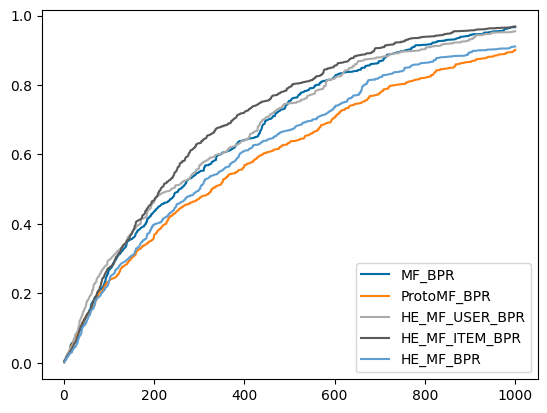

In [4]:
fig, ax = plt.subplots()

datasetName = "ML100K_IMPLICIT"
for modelName in ["MF_BPR", "ProtoMF_BPR", "HE_MF_USER_BPR", "HE_MF_ITEM_BPR", "HE_MF_BPR"]:

    values = []
    for seed in range(3):
        DATA, topk_indices = restoreDataAndPrediction(datasetName, modelName, seed)
        true_item_ids = DATA["df_EVALUATION"]["true_item_ids"]
        true_item_len = DATA["df_EVALUATION"]["true_item_len"]
        hit_flags = jax.vmap(lambda a, b: jnp.isin(a, b), in_axes=(0, 0), out_axes=(0))(topk_indices, DATA["df_EVALUATION"]["true_item_ids"]).astype(int)
        hit_flags_cumsum = hit_flags.cumsum(axis=1)
        recall_at_k = (hit_flags_cumsum.T / true_item_len).T.mean(axis=0)
        values.append( recall_at_k )

    recall_at_k = sum(values) / 3
    ax.plot( range(1, 1001), recall_at_k, label=modelName )

plt.legend()
plt.show()

ML1M_IMPLICIT-MF_BPR-TEST 0
[18]


ML1M_IMPLICIT-MF_BPR-TEST 1
[10]


ML1M_IMPLICIT-MF_BPR-TEST 2
[0, 1, 2, 3, 4, 5, 6]


ML1M_IMPLICIT-HE_MF_BPR-TEST 0
[19]


ML1M_IMPLICIT-HE_MF_BPR-TEST 1
[13]


ML1M_IMPLICIT-HE_MF_BPR-TEST 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


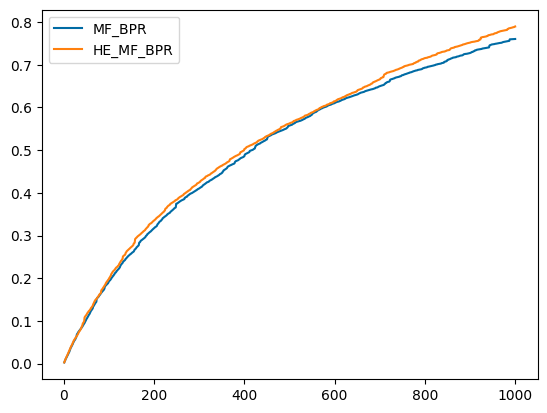

In [5]:
fig, ax = plt.subplots()

datasetName = "ML1M_IMPLICIT"
for modelName in ["MF_BPR", "HE_MF_BPR"]:

    values = []
    for seed in range(3):
        DATA, topk_indices = restoreDataAndPrediction(datasetName, modelName, seed)
        true_item_ids = DATA["df_EVALUATION"]["true_item_ids"]
        true_item_len = DATA["df_EVALUATION"]["true_item_len"]
        hit_flags = jax.vmap(lambda a, b: jnp.isin(a, b), in_axes=(0, 0), out_axes=(0))(topk_indices, DATA["df_EVALUATION"]["true_item_ids"]).astype(int)
        hit_flags_cumsum = hit_flags.cumsum(axis=1)
        recall_at_k = (hit_flags_cumsum.T / true_item_len).T.mean(axis=0)
        values.append( recall_at_k )

    recall_at_k = sum(values) / 3
    ax.plot( range(1, 1001), recall_at_k, label=modelName )

plt.legend()
plt.show()

Twitch100K-MF_BPR-TEST 0
[76]


Twitch100K-MF_BPR-TEST 1
[25]


Twitch100K-MF_BPR-TEST 2
[6]


Twitch100K-HE_MF_BPR-TEST 0
[76]


Twitch100K-HE_MF_BPR-TEST 1
[107]


Twitch100K-HE_MF_BPR-TEST 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


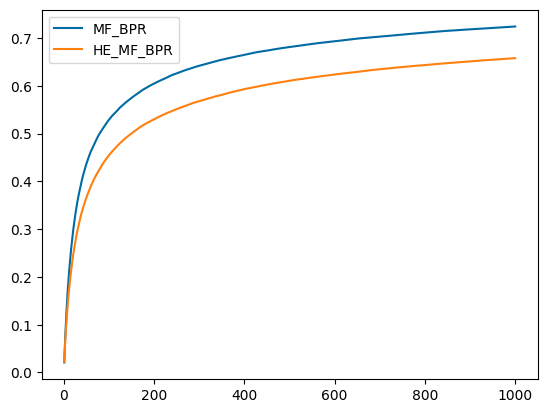

In [6]:
fig, ax = plt.subplots()

datasetName = "Twitch100K"
for modelName in ["MF_BPR", "HE_MF_BPR"]:

    values = []
    for seed in range(3):
        DATA, topk_indices = restoreDataAndPrediction(datasetName, modelName, seed)
        true_item_ids = DATA["df_EVALUATION"]["true_item_ids"]
        true_item_len = DATA["df_EVALUATION"]["true_item_len"]
        hit_flags = jax.vmap(lambda a, b: jnp.isin(a, b), in_axes=(0, 0), out_axes=(0))(topk_indices, DATA["df_EVALUATION"]["true_item_ids"]).astype(int)
        hit_flags_cumsum = hit_flags.cumsum(axis=1)
        recall_at_k = (hit_flags_cumsum.T / true_item_len).T.mean(axis=0)
        values.append( recall_at_k )

    recall_at_k = sum(values) / 3
    ax.plot( range(1, 1001), recall_at_k, label=modelName )

plt.legend()
plt.show()